In [1]:
#import packages for data analysis 
import pandas as pd
import os
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
#importing the data
tue_data = pd.read_csv("takehome_user_engagement.csv")
tu_data = pd.read_csv("takehome_users.csv", encoding = "ANSI")

Major task: Predict which users have adopted the service; users that have logged in at least 3 separate days in one week. 

First find users in "tue" that have logged in on three separate days in one week

In [3]:
#convert time_stamp to timestamp
tue_data.time_stamp = pd.to_datetime(tue_data.time_stamp)

In [4]:
#create a list of unique users
un_u = list(set(list(tue_data.user_id)))

In [5]:
#create a dictionary of dataframes where each dataframe logs a users activity
lul = {}
for i in un_u:
    lul[i] = tue_data[tue_data.user_id == i]
    lul[i].index = lul[i].time_stamp
    #print(i) #takes 30 seconds

In [6]:
#deleting entries in ldu_oh with less than three rows reduction by 2/3
lul_r = {}    
for key in lul:
    if len(lul[key]) > 3:
        lul_r[key] = lul[key]

In [7]:
#find adopted users
lul_au = {}
for key in lul_r:
    lrk = lul_r[key].resample("7D").count()
    if lrk.visited.max() >= 3:
        lul_au[key] = lul_r[key]

In [8]:
#list of adopted users
lau = lul_au.keys()

#creating boolean column of adpoted user
bc_au = []
for i in tu_data.object_id:
    bc_au.append(i in lau)

bc_au = np.array(bc_au)*1

Can I predict an adopted user?

I expect the major predictors of adoption to be 'creation source', 'opted in', 'enabled for marketing drip', 'org id', and 'invited by user'.

In [9]:
#cleaning these columns
tu_data.invited_by_user_id = tu_data.invited_by_user_id.fillna(-1) #replacing na here with -1
cleanup = dict(zip(list(set(list(tu_data.creation_source))),
                   list(range(0,len(list(set(list(tu_data.creation_source))))))))

tu_data.creation_source = tu_data.creation_source.replace(cleanup)

In [10]:
#PCA for visualization
pTD = tu_data[['creation_source', 'opted_in_to_mailing_list', 
               'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']]

#import pca packages
from sklearn.decomposition import PCA
from sklearn import preprocessing

# normalize data
npTD = pd.DataFrame(preprocessing.scale(pTD),columns = pTD.columns) 

#transpose data
tnpTD = pd.DataFrame.transpose(npTD) 

#fit the data
pca = PCA()

pca_x = pca.fit_transform(tnpTD)

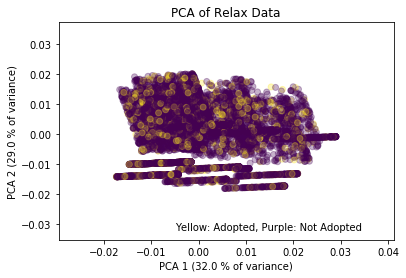

In [11]:
#Plot the plot
plt.scatter(pca.components_[0,:],pca.components_[1,:], alpha = 0.3, c = bc_au)
plt.xlabel('PCA 1 ({} % of variance)'.format((pca.explained_variance_ratio_[0]*100).round()))
plt.ylabel('PCA 2 ({} % of variance)'.format((pca.explained_variance_ratio_[1]*100).round()))
plt.text(-0.005, -0.032, 'Yellow: Adopted, Purple: Not Adopted')
plt.title('PCA of Relax Data')
plt.show()

As can be seen the above plot, little to no speration exists between users who adopted the service (yellow) and those who did not (purple). 

Can adopted users be predicted through logistic regression?

In [13]:
#import packages
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [14]:
# Create training and test sets
npTD_train, npTD_test, bc_au_train, bc_au_test = train_test_split(npTD, bc_au, test_size = 0.3, random_state=42)

In [15]:
# Create the classifier: logreg
logreg = LogisticRegression()

In [16]:
# Fit the classifier to the training data
logreg.fit(npTD_train, bc_au_train)

C:\Users\websterkgd\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
# Predict the labels of the test set: y_pred
bc_au_pred = logreg.predict(npTD_test)

In [18]:
# Compute and print the confusion matrix and classification report
print(confusion_matrix(bc_au_test, bc_au_pred))
print(classification_report(bc_au_test, bc_au_pred))

[[3155    0]
 [ 445    0]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      3155
           1       0.00      0.00      0.00       445

    accuracy                           0.88      3600
   macro avg       0.44      0.50      0.47      3600
weighted avg       0.77      0.88      0.82      3600



C:\Users\websterkgd\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The confusion matrix and the classification report show that the logistic regression model could not seperate adopted users from those who did not adopt, and was overwhelmed by the number of users who did not adopt the service.   

The resulting analysis shows, along with the PCA plot, that there is not a lot of seperation between the users that adopt the service and those that do not. The logistic regression analysis shows that none of the adopted  users were correctly predicted. This is due to the weak clustering present in the data. My suggestion for Relax is to potentially redefine adopted users. I think one potential issue is that their definition may be too narrow to  capture users that routinely interact with the site. In future analyses I may consider redefining an adopted user for Relax to potentially deliver more insight. Another suggestion may be to class organization by type, rather than by each institution.   